# Clone FasterRCNN and Installation

In [ ]:
!git clone https://github.com/GitarthVaishnav/FasterRCNN42028.git

In [2]:
%cd FasterRCNN42028/

/content/FasterRCNN42028


In [ ]:
!pip install -r requirements.txt

In [42]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time
import argparse
import yaml
import matplotlib.pyplot as plt

from models.create_fasterrcnn_model import create_model
from utils.general import set_infer_dir
from utils.transforms import infer_transforms, resize

## Get all imag in the folder

In [6]:
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images  

# Config and get pretrained model

In [47]:
DIR_TEST = "/content/100004.jpg"              # File ảnh hoặc thư mục ảnh bạn muốn predict
OUT_DIR =  "/content"                         # Thư mục để bạn lưu kết quả predict
PATH_MODEL = '/content/best_model.pth'        # File Model đã train với data của bạn
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
detection_threshold = 0.35
DEVICE

device(type='cpu')

In [ ]:
checkpoint = torch.load(PATH_MODEL, map_location=DEVICE)
# If config file is not given, load from model dictionary.

NUM_CLASSES = checkpoint['config']['NC']
CLASSES = checkpoint['config']['CLASSES']

print('Building from model name arguments...')
build_model = create_model['fasterrcnn_resnet50_fpn']

model = build_model(num_classes=NUM_CLASSES, coco_model=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

In [28]:
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [11]:
test_images = collect_all_images(DIR_TEST)
test_images

['/content/100004.jpg']

In [57]:
def inference_annotations(
    outputs, 
    detection_threshold, 
    classes,
    colors, 
    orig_image, 
    image
):
    height, width, _ = orig_image.shape
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # Filter out boxes according to `detection_threshold`.
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # Get all the predicited class names.
    
    pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]

    lw = max(round(sum(orig_image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    
    # Draw the bounding boxes and write the class name on top of it.
    for j, box in enumerate(draw_boxes):
        p1 = (int(box[0]/image.shape[1]*width), int(box[1]/image.shape[0]*height))
        p2 = (int(box[2]/image.shape[1]*width), int(box[3]/image.shape[0]*height))
        class_name = pred_classes[j]
        color = colors[classes.index(class_name)]
        cv2.rectangle(
            orig_image,
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        )
        if True:
            # For filled rectangle.
            final_label = class_name + ' ' + str(round(scores[j], 2))
            w, h = cv2.getTextSize(
                final_label, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw / 3, 
                thickness=tf
            )[0]  # text width, height
            w = int(w - (0.20 * w))
            outside = p1[1] - h >= 3
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                orig_image, 
                p1, 
                p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                orig_image, 
                final_label, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw / 3.8, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return orig_image

# Predict Image

In [58]:
def preidict(dir_image):
  test_images = collect_all_images(DIR_TEST)
  for i in range(len(test_images)):
  # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    orig_image = cv2.imread(test_images[i])
    frame_height, frame_width, _ = orig_image.shape

    image_resized = resize(orig_image, frame_width)
    image = image_resized.copy()
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = infer_transforms(image)
    # Add batch dimension.
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    if DEVICE=='gpu':
      outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    if len(outputs[0]['boxes']) != 0:
        orig_image = inference_annotations(
                                          outputs, 
                                          detection_threshold, 
                                          CLASSES,
                                          COLORS, 
                                          orig_image, 
                                          image_resized
                                          )

    plt.imshow(orig_image[:, :, ::-1])
    plt.axis('off')
    plt.show()
    cv2.imwrite(f"{OUT_DIR}/{image_name}.jpg", orig_image)
    print(f"{OUT_DIR}/{image_name}.jpg")
    
    print(f"Image {i+1} done...")
    print(f"Time Predict {end_time}")
    print('-'*50)

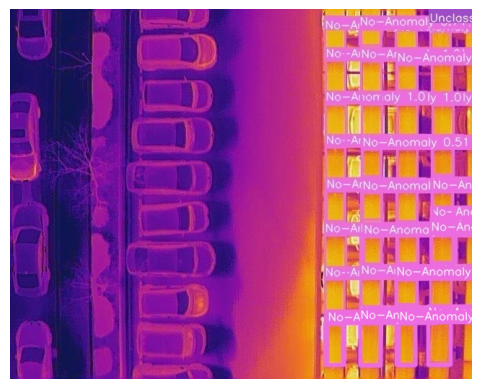

/content/100004.jpg
Image 1 done...
Time Predict 1684861897.5493336
--------------------------------------------------


In [59]:
preidict('/content/100004.jpg')

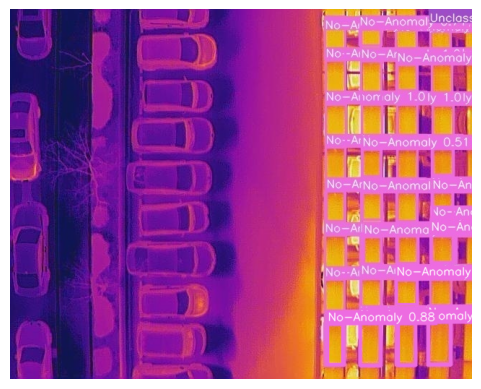

/content/100004.jpg
Image 1 done...
Time Predict 1684861802.5097423
--------------------------------------------------


In [56]:
preidict('/content/100040.jpg')

In [ ]:
preidict('/content/100045.jpg')